In [22]:
# imports
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()


**For uniform results, random seed is required**

In [23]:
tf.random.set_seed(100)
np.random.seed(100)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 1. EDA

In [24]:
path = "/kaggle/input/cxr-for-cptn/Dataset/"
os.listdir(path)

['PNEUMONIA', 'TUBERCULOSIS', 'NORMAL', 'COVID-19']

## Distibution of data

In [25]:
path = '/kaggle/input/cxr-for-cptn/Dataset'
path2 = '/kaggle/input/more-healthy-cxr'
images = []
labels = []

for label in os.listdir(path):
    label_dir = os.path.join(path, label)
    for img in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img)
        images.append(img_path)
        labels.append(label)
    images, labels = shuffle(images,labels)
for labl in os.listdir(path2):
    labl_path = os.path.join(path2, labl)
    for imgs in os.listdir(labl_path):
        imgs_path = os.path.join(labl_path,imgs)
        images.append(imgs_path)
        labels.append(labl)
    images, labels = shuffle(images, labels)
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':images, 'label':labels})
df.head()

,path,label
0,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1547_virus_2688.jpeg,PNEUMONIA
1,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0033-0001-0001.jpeg,NORMAL
2,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person645_bacteria_2537.jpeg,PNEUMONIA
3,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person4_bacteria_14.jpeg,PNEUMONIA
4,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1449_virus_2474.jpeg,PNEUMONIA


In [26]:
print("shape of data:",df.shape)
print("------------------------------------")
print("Column names:", df.columns)

shape of data: (13188, 2)
------------------------------------
Column names: Index(['path', 'label'], dtype='object')


In [27]:
df['label'].value_counts()

NORMAL          4599
PNEUMONIA       4273
COVID-19        3616
TUBERCULOSIS     700
Name: label, dtype: int64

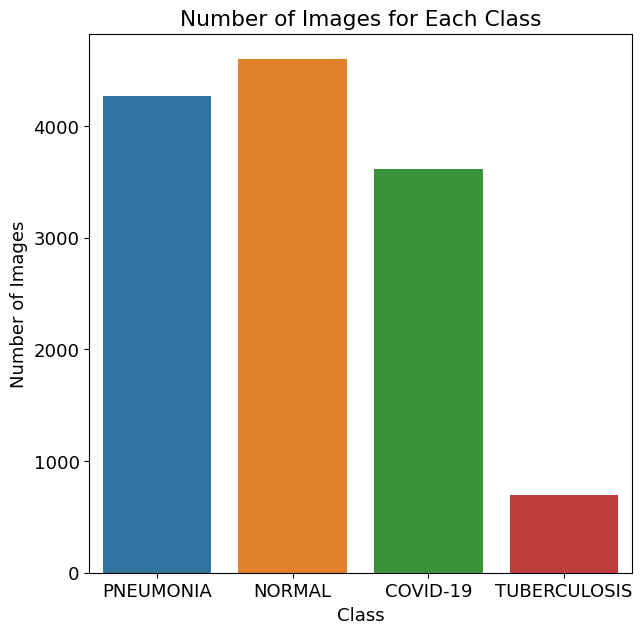

In [28]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Class')
plt.show()

## Splitting the data into train, test and validation : 80%, 10% and 10%

It is generally recommended to split the data into train, test, and validation sets before preprocessing the data. This is because preprocessing techniques such as normalization, scaling, and feature selection are often based on the statistics of the training set, and applying these techniques before splitting the data can lead to data leakage and overfitting

In [29]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets with stratified sampling
train_val, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
# Split the train set into train and validation sets with stratified sampling
train_df, val_df = train_test_split(train_val, test_size=0.1, stratify=train_val['label'], random_state=42)

In [30]:
print("Original train+val set:", train_val.shape)
print("Train set:",train_df.shape)
print("Test set:",test_df.shape)
print("Val set:",val_df.shape)

Original train+val set: (11869, 2)
Train set: (10682, 2)
Test set: (1319, 2)
Val set: (1187, 2)


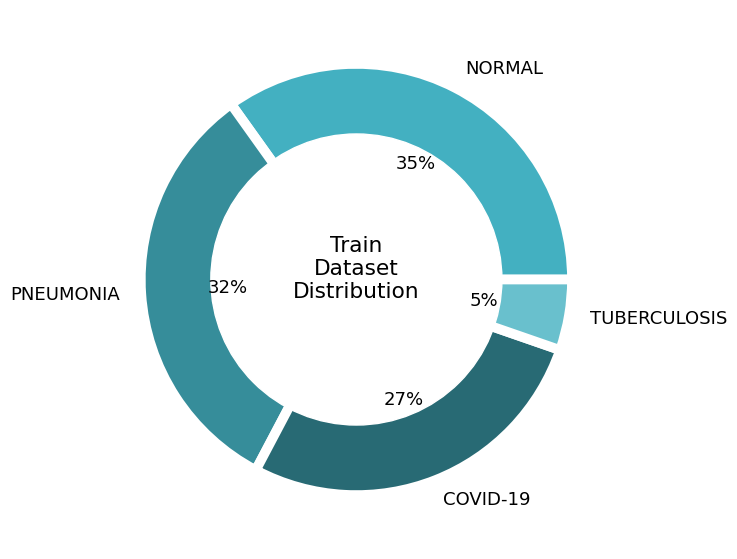

In [31]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
# plotting data on chart
plt.pie(list(df.label.value_counts()),
        labels=list(train_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Train\nDataset\nDistribution', x=0.5, y=0.45) 
plt.show()

From the total dataset distribution, pneumonia images accounts for more that half of the dataset with 42% while tuberculosis instances accounts for only 7% ot the total dataset. Other classes for normal and Covid-19 accounts for 16% and 36% respectively. 

# 2. Pre-processing
Image Augmentation is a process that is used to create new images for training by slightly altering the pixel values.
We have a small dataset, so we can apply some image augmentation techniques to prevent overfitting of the model.
Techniques we will be using are:

1. Change the brightness of an image by a factor between 0.67 to 1.33
2. Change the contrast of an image by a factor between 0.67 to 1.33

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class configurations:
    IMAGE_SIZE = 224
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST = (0.64, 1.37) # (MIX, MAX)
    BATCH_SIZE = 32
    EPOCHS = 15
    LEARNING_RATE = 0.001
def augment_image(image):
    datagen = ImageDataGenerator(
        brightness_range=configurations.BRIGHTNESS,
        rescale = 1./255
        #vertical_flip=True,
        #rotation_range=20,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2
    )
    # Convert input image from numpy to PIL Image
    image = np.expand_dims(image, axis=0)
    # Apply Transformations
    image = datagen.flow(image, batch_size=1)[0][0]
    return image

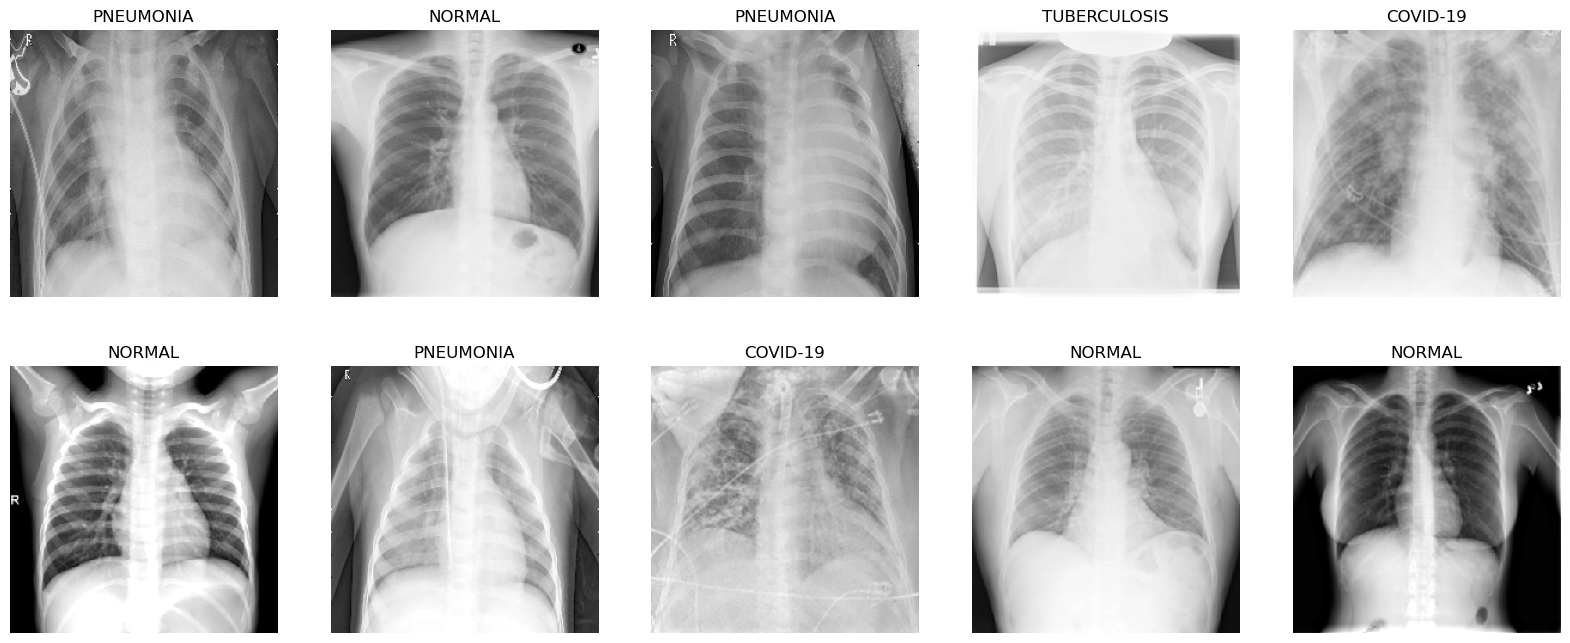

In [33]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(configurations.IMAGE_SIZE,configurations.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(train_df.path[k:k+10])
labels = list(train_df.label[k:k+10])
images = open_images(image_paths, augment=True)
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

## 2.1 Label encoder-decoder
1. Creating a dictionary label_encoder to convert string label to interger-encoded label
2. And another dictionary label_decoder to decode the integer-encoded label

In [34]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID-19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID-19'}

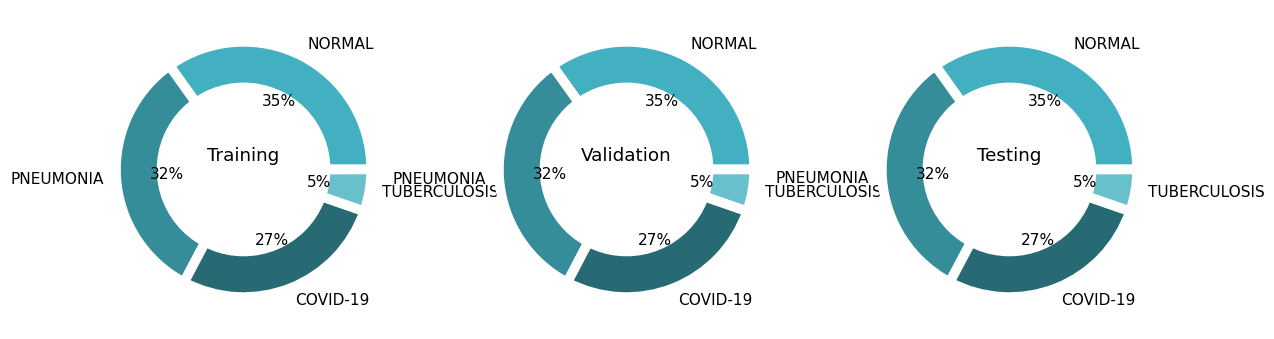

In [35]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 3, 1)
plt.pie(list(train_df.label.value_counts()),
        labels=list(train_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 3, 2)
plt.pie(list(val_df.label.value_counts()),
        labels=list(val_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

fig.add_subplot(1, 3, 3)
plt.pie(list(test_df.label.value_counts()),
        labels=list(test_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Testing', x=0.5, y=0.5) 
plt.show()

Training a model on this highly imbalanced dataset will cause the model to overfit on the class that is in excess and fail to learn patterns from other classes. Fortunately, there are ways to tackle this problem. What we will be doing is assigning "class weights" to the classes, to handle the imbalanced classes. This will be computed in the later sections

## 2.3 Data Generators
data_generator is the generator function which we will use for training. It has 4 input parameters:

1. > df: This is the dataframe containing the image paths and labels \n
1. > batch_size (int): Batch size of training samples
1. > augment (boolean): If true, the augmentation techniques defined before will be applied to the images. We will set this to True during training and False during validation
1. > epochs (int): Number of epochs

In [36]:
def data_generator(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [37]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(train_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_steps = int(len(train_df)/configurations.BATCH_SIZE)

val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_steps = int(len(val_df)/configurations.BATCH_SIZE)

# 3. Model

## 3.1 Model architecture 
* We are utilizing the inspiration of ResNet-50 model

In [38]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add

In [39]:
resnet_model= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
for layer in resnet_model.layers[:-10]:
    layers.trainable=False
hm = resnet_model.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)

model = Model(inputs=resnet_model.input, outputs = hm)

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## 3.2 Compile

This is the loss function we will be using:  

$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [y_i\text{log}(\hat y_i) + (1-y_i)\text{log}(1-\hat y_i)]$$
where,  
$\quad\hat y$ is the predicted label, and $y$ is the actual label  
$\quad y_i$ is the $i^\mathbf{th}$ sample of $y$  and $\hat y_i$ is the $i^\mathbf{th}$ sample of $\hat y$  
$\quad N$ is the number of samples

`sparse_categorical_crossentropy` and `categorical_crossentropy` are basically the same loss functions, just their input formats are different.  
If $y_i$ is <b><mark>one-hot encoded</mark></b>, we use `categorical_crossentropy`, and if $y_i$ is <b><mark>integer-encoded</mark></b>, we use `sparse_categorical_crossentropy`  
For our case, the labels from the data generators are <b><mark>integer-encoded</mark></b>, so we are using `sparse_categorical_crossentropy`  

In [41]:
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(configurations.LEARNING_RATE)
model.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
#            loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

# 3.3 Training the model

In this phase, we will use our dataset to train our model first without handling class imbalance problems and later, when handling the class imbalance problem using different approaches.

In [42]:
model_checkpoint_callback_imb = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model_imb.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history_imb = model.fit(train_data_generator, epochs=configurations.EPOCHS, steps_per_epoch=train_steps,
          validation_data=val_data_generator, validation_steps=val_steps, callbacks=[model_checkpoint_callback_imb])

Epoch 1/15
333/333 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.7026
Epoch 1: val_accuracy improved from -inf to 0.36909, saving model to /kaggle/working/model_imb.hdf5
333/333 [==============================] - 163s 442ms/step - loss: 0.7457 - accuracy: 0.7026 - val_loss: 1.3172 - val_accuracy: 0.3691
Epoch 2/15
333/333 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8781
Epoch 2: val_accuracy improved from 0.36909 to 0.38936, saving model to /kaggle/working/model_imb.hdf5
333/333 [==============================] - 105s 310ms/step - loss: 0.3428 - accuracy: 0.8781 - val_loss: 1.4629 - val_accuracy: 0.3894
Epoch 3/15
333/333 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9225
Epoch 3: val_accuracy improved from 0.38936 to 0.72382, saving model to /kaggle/working/model_imb.hdf5
333/333 [==============================] - 104s 312ms/step - loss: 0.2269 - accuracy: 0.9225 - val_loss: 0.6879 - val_accuracy: 0.7238
E

**Evaluate the performance**

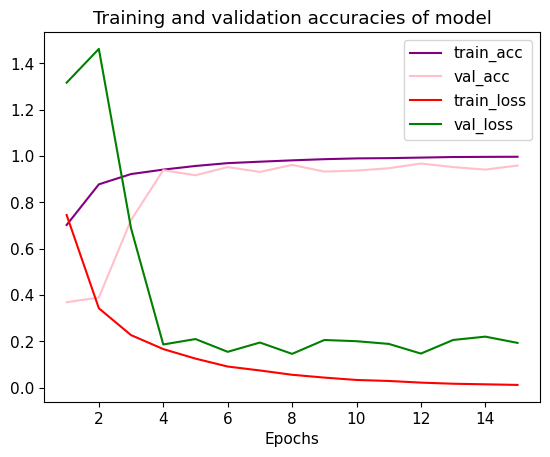

In [43]:
epochs_imb = range (1, len(history_imb.history['accuracy']) + 1)
plt.plot(epochs_imb, history_imb.history['accuracy'], color = 'purple')
plt.plot(epochs_imb, history_imb.history['val_accuracy'], color = 'pink')
plt.plot(epochs_imb, history_imb.history['loss'], color = 'red')
plt.plot(epochs_imb, history_imb.history['val_loss'], color = 'green')
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training and validation accuracies of model')
plt.legend(["train_acc","val_acc","train_loss","val_loss"], loc = "upper right")
plt.show()

From the plot, the accuracy of our model rises from the first epoch until it reaches the maximum point of 0.99. The validation accuracy of the model reaches highest of 0.96. Both the training loss and validation loss shows a downward trend in both the train and validation set. To evaluate its performance across the 4 classes, we can look at the classification report of our model that shows the precision, recall and F1-score performances.

In [44]:
val_data_generator_imb = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
val_steps_imb = int(len(val_df)/configurations.BATCH_SIZE)

y_pred_imb = []
y_true_imb = []

for x,y in tqdm(val_data_generator_imb, total=val_steps_imb):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred_imb.append(label_decoder[i])
    for i in y:
        y_true_imb.append(label_decoder[i])
clear_output()
print(classification_report(y_true_imb, y_pred_imb, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9712    0.9323    0.9513       325
      NORMAL     0.9238    0.9662    0.9445       414
   PNEUMONIA     0.9842    0.9714    0.9778       385
TUBERCULOSIS     1.0000    0.9841    0.9920        63

    accuracy                         0.9596      1187
   macro avg     0.9698    0.9635    0.9664      1187
weighted avg     0.9604    0.9596    0.9597      1187



### **Interpretation of these results**

The results gives a confusion matrix/classification report of the covid-tuberculosis-pneumonia-normal dataset.The detailed description is shown as:

    1. Precision - Describes number of predicted positive instances that are actually true positive. A high precision indicates that the model has low rate of false positives. From the 4 classes in the dataset, our model shows good recall of above .95
    
    2. Recall - measures how many actual positive instances were correctly predicted by the model. High recall indicates the model is good at capturing positive instances. The recall for covid-19 and tuberculosis instances are slightly high compared to the other two classes. 
    
    3. F1-score - Describes the harmonic mean of precision and recall. It provides a balanced measure between precision and recall and it's a good metric for the imbalanced dataset, like ours. A high F1-score indicates a good balance between precision and recall. Our model has a good F1-score where all classes have a score above .9
    
    The overall accuracy of the model is 96.51 which is a good performance for the model on the dataset.
    
    In this problem, both false positives and false negatives are equally important .
    
    False Negatives - These occur when the model predicts a negative class (e.g., "NORMAL" in a medical context) when it should have predicted a positive class (e.g., "COVID-19"). False negatives can be particularly problematic in situations where missing a positive case could have severe consequences. For instance, in medical diagnoses, failing to identify a disease like COVID-19 could lead to delayed treatment and potential harm to the patient.
    
    False Positives - These happen when the model predicts a positive class when it should have predicted a negative class. In medical scenarios, this could lead to unnecessary treatments, tests, or alarms, causing inconvenience and potential costs to patients and healthcare providers.
    
    As a result, the most important evaluation metric for our data is F1-score 

## Training models by handling class imbalance

## 1. Handling class imbalance with class weighting approach

With class weighting approach, we use class weights to tackle the imbalanced dataset problem. Using our loss function, the cross-entropy loss function, we will create a bias towards the dominating class. So, we will apply multipliers, or 'weights' to balance the loss function. This is called a <b><mark>weighted loss function</mark></b>:  
$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [w_p y_i\text{log}(\hat y_i) + w_n (1-y_i)\text{log}(1-\hat y_i)]$$

So how do we calculate these so called weights $w_p$ and $w_n$ for each class? Just calculate the proportion of the dataset each class represents and tensorflow will handle the rest.  
`class_weights` is a dictionary of format `{'CLASS':'PROPORTION'}`

In [45]:
class_weights = (train_df.label.value_counts() / len(train_df)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{0: 0.3487174686388317,
 2: 0.32400299569369034,
 3: 0.2741995880921176,
 1: 0.05307994757536042}

Text(0.5, 1.0, 'Class Weights for Each Class')

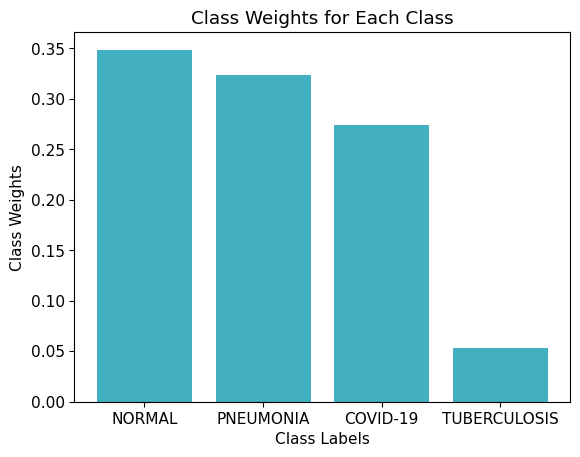

In [46]:
# distribution of the class weights
class_labels_w = [label_decoder[label] for label in class_weights.keys()]
weights = list(class_weights.values())

plt.bar(class_labels_w, weights, color='#43b0c1')
plt.xlabel('Class Labels')
plt.ylabel('Class Weights')
plt.title('Class Weights for Each Class')

In [47]:
# generator for class_weighting
def data_generator_weighting(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [48]:
train_data_generator_weighting = data_generator_weighting(train_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_steps_weighting = int(len(train_df)/configurations.BATCH_SIZE)

val_data_generator_weighting = data_generator_weighting(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_steps_weighting = int(len(val_df)/configurations.BATCH_SIZE)

In [49]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 5)

history = model.fit(train_data_generator_weighting, epochs=configurations.EPOCHS, steps_per_epoch=train_steps_weighting,
          validation_data=val_data_generator_weighting, validation_steps=val_steps_weighting,class_weight = class_weights, callbacks=[model_checkpoint_callback])

Epoch 1/15
333/333 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9975
Epoch 1: val_accuracy improved from -inf to 0.96453, saving model to /kaggle/working/model.hdf5
333/333 [==============================] - 120s 318ms/step - loss: 0.0027 - accuracy: 0.9975 - val_loss: 0.1581 - val_accuracy: 0.9645
Epoch 2/15
333/333 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9977
Epoch 2: val_accuracy did not improve from 0.96453
333/333 [==============================] - 107s 321ms/step - loss: 0.0027 - accuracy: 0.9977 - val_loss: 0.1746 - val_accuracy: 0.9637
Epoch 3/15
333/333 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9979
Epoch 3: val_accuracy improved from 0.96453 to 0.96875, saving model to /kaggle/working/model.hdf5
333/333 [==============================] - 105s 316ms/step - loss: 0.0024 - accuracy: 0.9979 - val_loss: 0.1607 - val_accuracy: 0.9688
Epoch 4/15
333/333 [==============================] - ETA: 0s

# 4. Evaluate the model

In [50]:
val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(val_df)/configurations.BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9687    0.9508    0.9596       325
      NORMAL     0.9435    0.9686    0.9559       414
   PNEUMONIA     0.9895    0.9792    0.9843       385
TUBERCULOSIS     1.0000    0.9841    0.9920        63

    accuracy                         0.9680      1187
   macro avg     0.9754    0.9707    0.9730      1187
weighted avg     0.9683    0.9680    0.9681      1187



# 5. Conclusion and Deployment

1/1 [==============================] - 0s 425ms/step


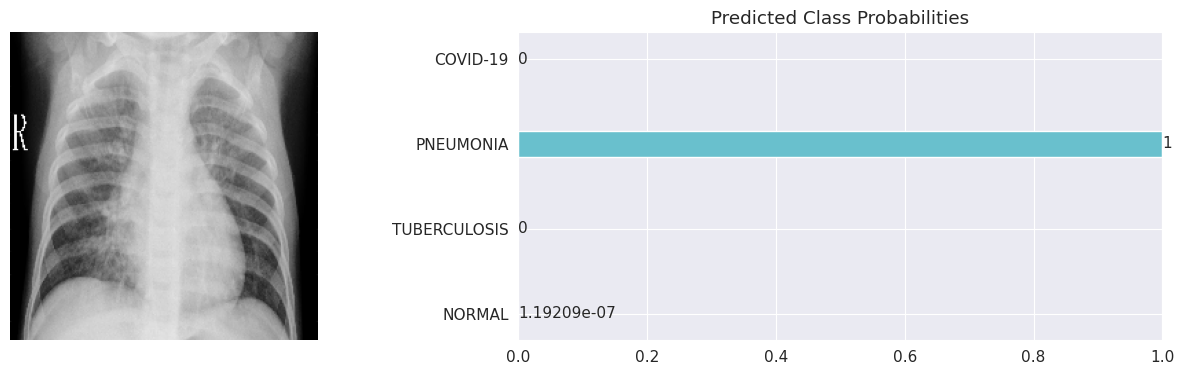

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 26ms/step


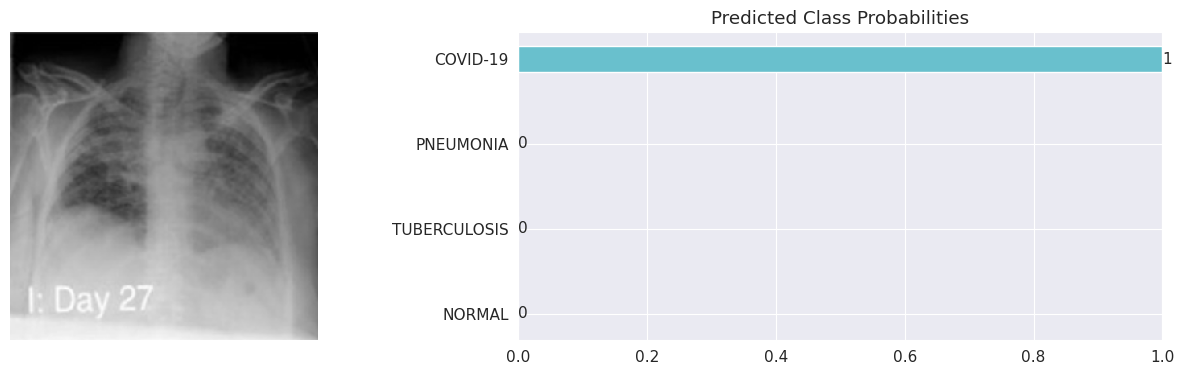

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 26ms/step


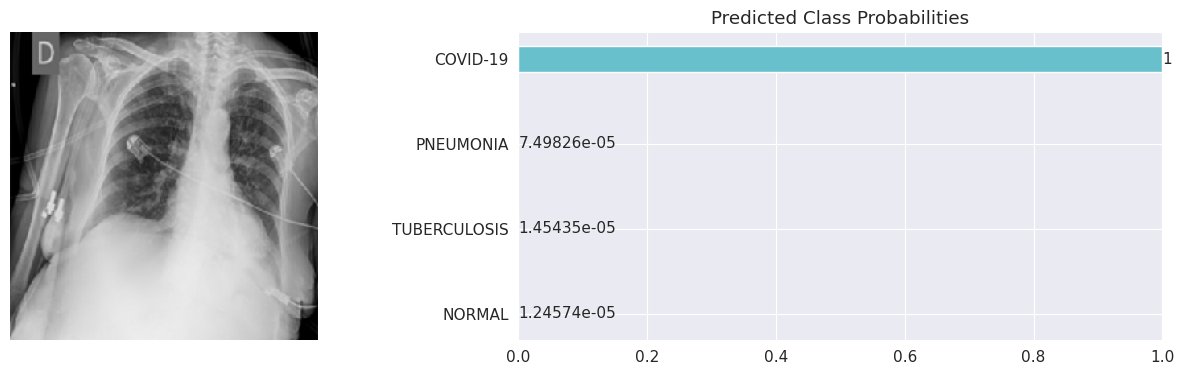

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 25ms/step


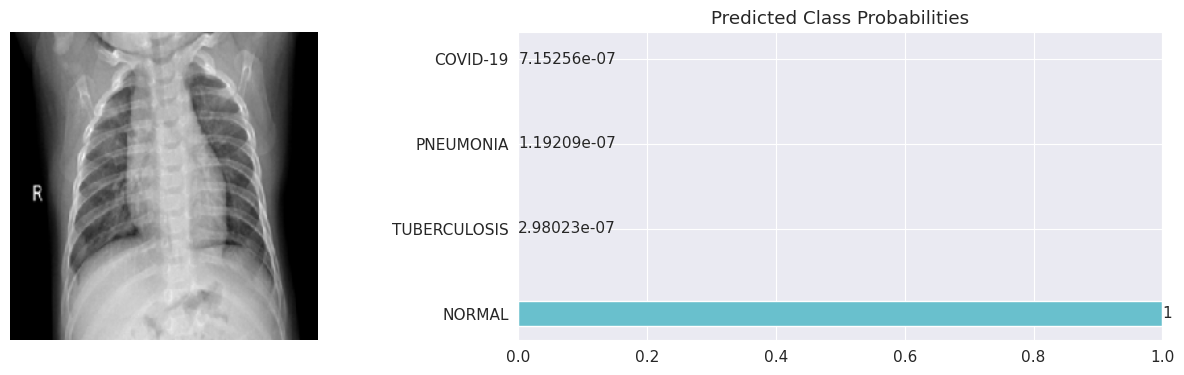

Actual   : NORMAL
Predicted: NORMAL
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


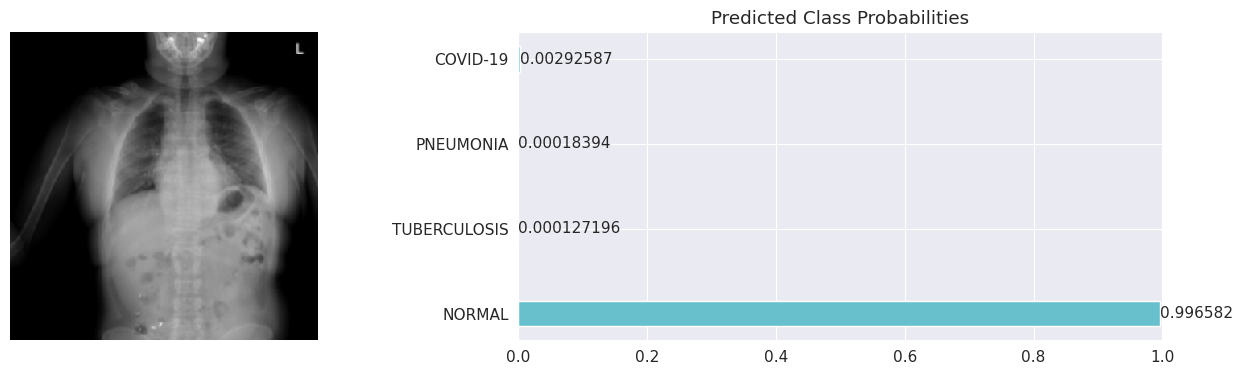

Actual   : NORMAL
Predicted: NORMAL
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


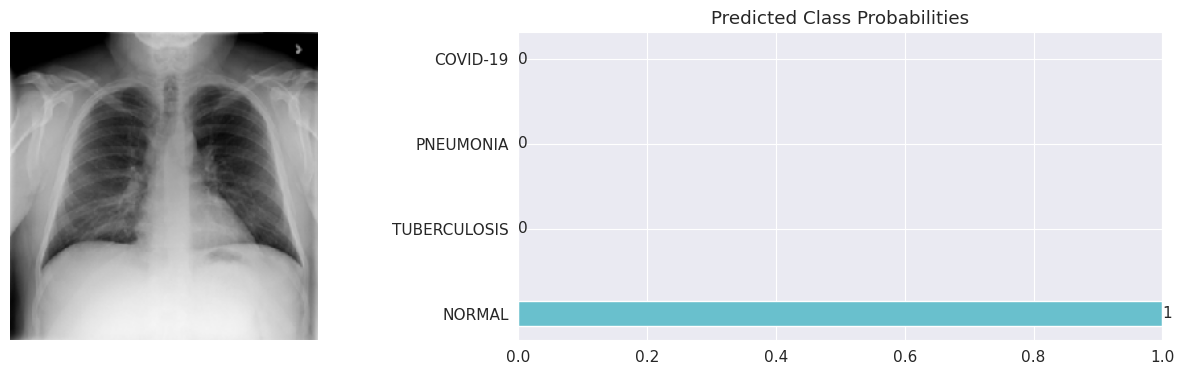

Actual   : NORMAL
Predicted: NORMAL
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


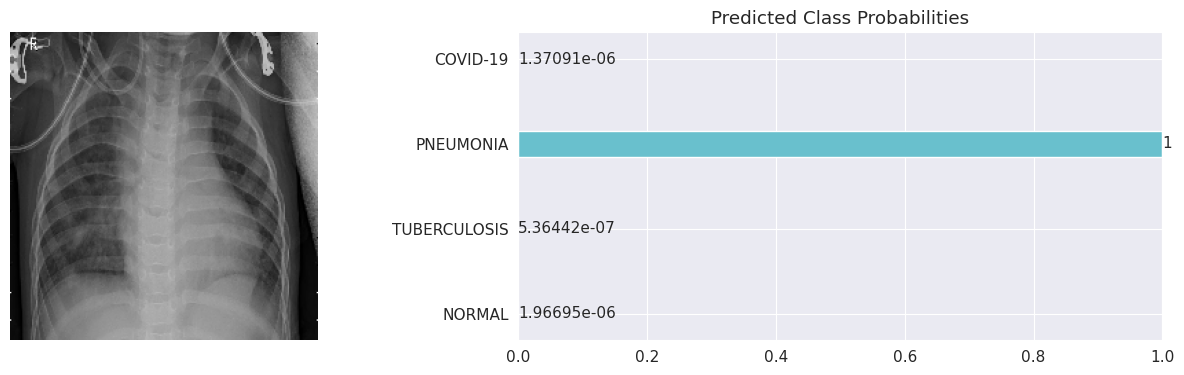

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------




In [51]:
def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels =  ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,configurations.IMAGE_SIZE,configurations.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(train_df.index), 7)

for INDEX in INDICES:

    image = load_img(train_df.path[INDEX], target_size=(configurations.IMAGE_SIZE, configurations.IMAGE_SIZE))
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)
    
    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',train_df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')